<img src="https://miro.medium.com/max/640/1*YH3b1fARO-bf6gU3kyzT4A.jpeg">

In [2]:
import torch 
from torchvision.transforms import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.optim import Adam
import matplotlib.pyplot as plt

In [2]:
image_size = 28
batch_size = 64
noise_length = 100
transform = transforms.Compose([
    transforms.ToTensor(),])

In [3]:
train_dataset = MNIST(root='./Data', train=True, download=True, transform=transform)
val_dataset = MNIST(root='./Data', train=False, download=True, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2, drop_last=True)

In [4]:
print(f'image size : {train_dataset[0][0].shape}')

image size : torch.Size([1, 28, 28])


In [5]:
## construct the Generator Netowrk
class G(nn.Module):
    def __init__(self) -> None:
        super(G, self).__init__()
        self.Generator= nn.Sequential(
            ## Take noise input
            nn.Linear(noise_length, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 28*28),
            nn.BatchNorm1d(28*28),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.Generator(x)
        x = x.view(x.shape[0], 1, image_size, image_size)
        return x

In [ ]:
net = G()
x = torch.rand(batch_size, noise_length)
out = net(x)
print(out.shape)

In [6]:
## construct the Generator Netowrk
class D(nn.Module):
    def __init__(self) -> None:
        super(D, self).__init__()
        self.Discriminator = nn.Sequential(
            nn.Conv2d(1, 64, 3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 64, 3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(30976, 10),
            nn.ReLU(),
            nn.Linear(10, 1), 
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.Discriminator(x)
        return x

In [ ]:
net = D()
x = torch.unsqueeze(train_dataset[0][0],0)
out = net(x)
print(out.shape)

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [8]:
loss_function = nn.BCELoss()

In [16]:
d = D().to(device)
d_optimizer = Adam(d.parameters(), lr = 0.001)
g = G().to(device)
g_optimizer = Adam(g.parameters(), lr = 0.001)

In [17]:
def run_generator(g_model, d_model, loss_function):
    g_model.train()
    ## run the genrator for at least one
    g_optimizer.zero_grad()
    noise = torch.rand(batch_size, noise_length).to(device)
    g_output = g_model(noise)
    d_out = d_model(g_output).squeeze(1)
    ## check how bad is the generator (should generate all image as 1)
    ## genrator should run multiple time to update his weight to be able to recognize as 1 (real image)
    real_label = torch.ones(batch_size).to(device)
    g_loss = loss_function(d_out, real_label)
    g_loss.backward()
    g_optimizer.step()
    return g_loss

In [18]:
def run_discriminator(x, g_model, d_model, loss_function):
    ## run the discremniator
    d_model.train()
    d_optimizer.zero_grad()
    real_label = torch.ones(batch_size).to(device)
    d_out_real = d_model(x).squeeze(1)
    loss_real = loss_function(d_out_real, real_label)

    noise = torch.rand(batch_size, noise_length).to(device)
    fake_label = torch.zeros(batch_size).to(device)
    with torch.no_grad():
        g_out = g_model(noise)
    
    d_out_fake = d_model(g_out).squeeze(1)
    loss_fake = loss_function(d_out_fake, fake_label)

    loss = (loss_real+ loss_fake) / 2
    loss.backward()
    d_optimizer.step()
    return loss

In [19]:
for i in range(20):
    Total_g_loss = 0.0
    Total_d_loss = 0.0
    for idx, (x, _) in enumerate(train_dataloader):
        x = x.to(device)
        g_loss = run_generator(g, d, loss_function)
        d_loss = run_discriminator(x, g, d, loss_function)

        Total_g_loss += g_loss
        Total_d_loss += d_loss

    Total_g_loss /= (idx+1)
    Total_d_loss /= (idx+1)
    if i%2 == 0:
        print(f'Epoch : {i}, ,  Generator Loss : {Total_g_loss}, Discriminator Loss : {Total_d_loss}')     

Epoch : 0, ,  Generator Loss : 14.887523651123047, Discriminator Loss : 0.009957121685147285
Epoch : 2, ,  Generator Loss : 11.06175708770752, Discriminator Loss : 0.015008191578090191
Epoch : 4, ,  Generator Loss : 10.417435646057129, Discriminator Loss : 0.012746223248541355
Epoch : 6, ,  Generator Loss : 10.827607154846191, Discriminator Loss : 0.006330269388854504
Epoch : 8, ,  Generator Loss : 9.384596824645996, Discriminator Loss : 0.013239975087344646
Epoch : 10, ,  Generator Loss : 11.986913681030273, Discriminator Loss : 0.0027579907327890396
Epoch : 12, ,  Generator Loss : 11.074505805969238, Discriminator Loss : 0.003426266834139824
Epoch : 14, ,  Generator Loss : 13.072101593017578, Discriminator Loss : 0.003308743704110384
Epoch : 16, ,  Generator Loss : 12.48933219909668, Discriminator Loss : 0.005629523657262325
Epoch : 18, ,  Generator Loss : 12.65566635131836, Discriminator Loss : 0.007371159736067057


In [20]:
torch.save(g.state_dict(), './Data/weight.pt')

In [21]:
g = G()
g.load_state_dict(torch.load('./Data/weight.pt'))

<All keys matched successfully>

In [22]:
with torch.no_grad():
    noise = torch.rand(20, noise_length)
    img = g(noise)

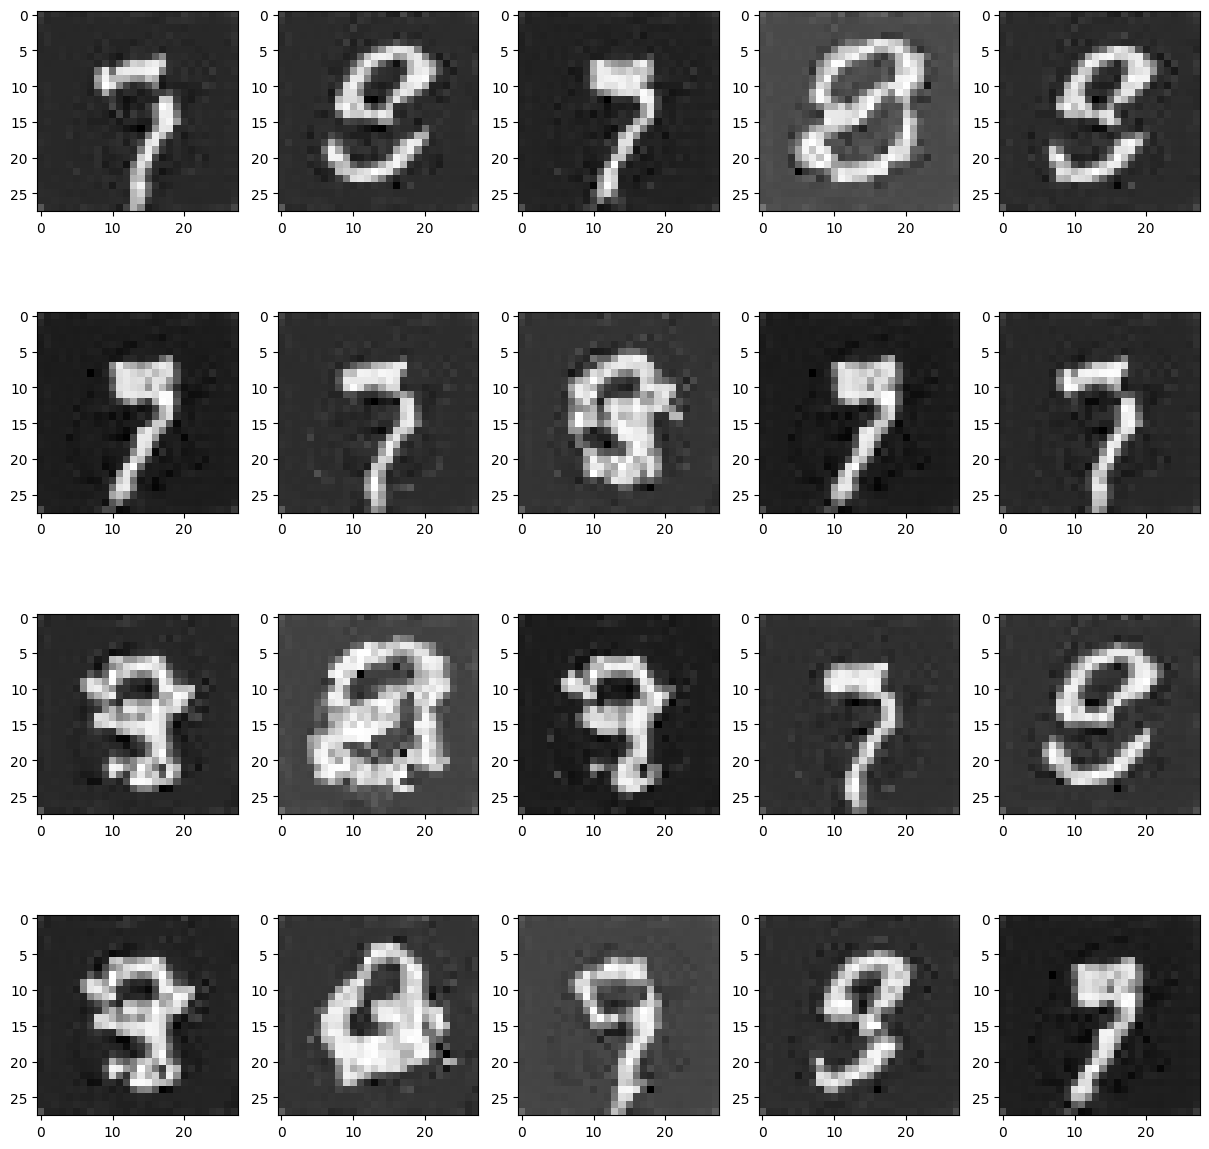

In [23]:
fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(15,15))
k=0
for i in range(4):
  for j in range(5):
    ax[i, j].imshow(img[k].squeeze(0), cmap='gray')
    k+=1